In [2]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs
!ls german-traffic-sign

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.
'ls' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
import pickle
import pandas as pd
import cv2
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from PIL import Image
import requests

%matplotlib inline

In [6]:
np.random.seed(0)
# TODO: Implement load the data here.
with open('german-traffic-signs/train.p', 'rb') as f:
    train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
    val_data = pickle.load(f)
# TODO: Load test data
with open('german-traffic-signs/test.p', 'rb') as f:
    test_data = pickle.load(f)
 
    
# Split out features and labels
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']
 
#already 4 dimensional
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
# STOP: Do not change the tests below. Your implementation should pass these tests. 
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels."
assert(X_train.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels."
assert(X_val.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels."
assert(X_test.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."

(34799, 32, 32, 3)
(12630, 32, 32, 3)
(4410, 32, 32, 3)


[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


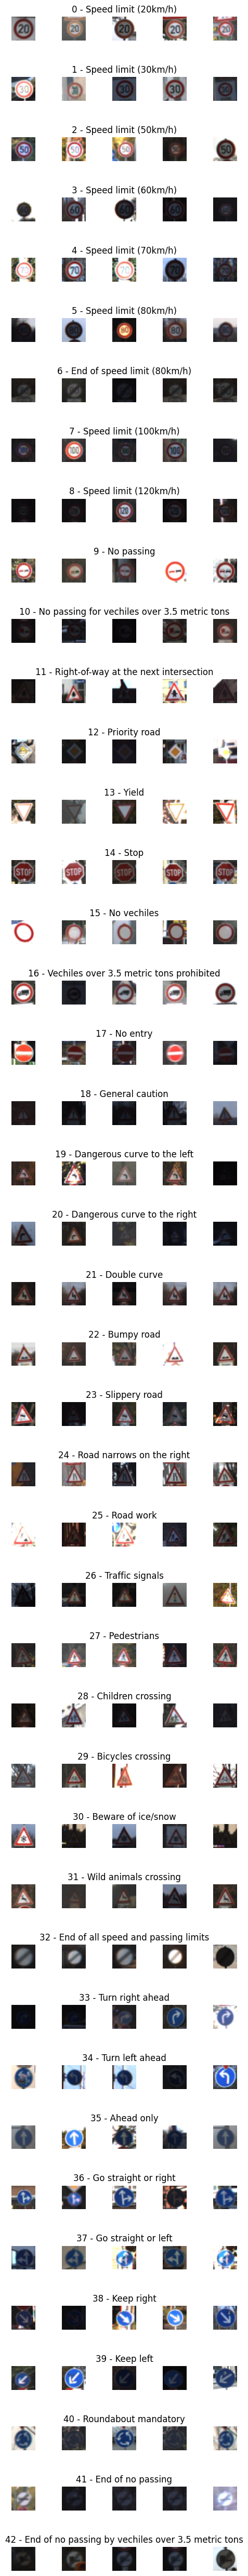

In [10]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
num_of_samples=[]
 
cols = 5
num_classes = 43
 
fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()
 
for i in range(cols):
  for j, row in data.iterrows():
    x_selected = X_train[y_train == j]
    axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
    axs[j][i].axis("off")
    if i == 2:
      axs[j][i].set_title(str(j) + " - " + row["SignName"])
      num_of_samples.append(len(x_selected))
print(num_of_samples)      


[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


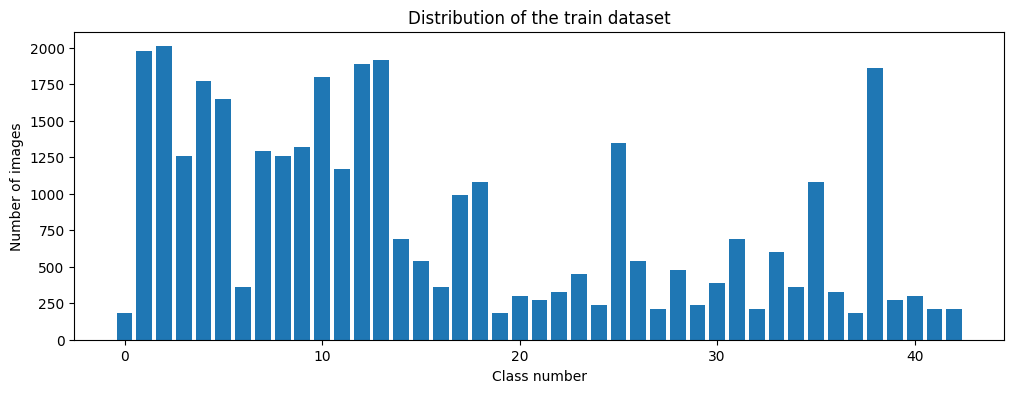

In [11]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

(32, 32, 1)
36


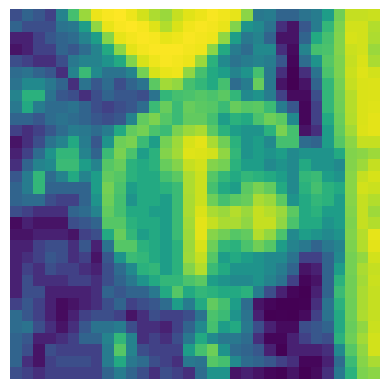

In [25]:
import cv2
 
plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])



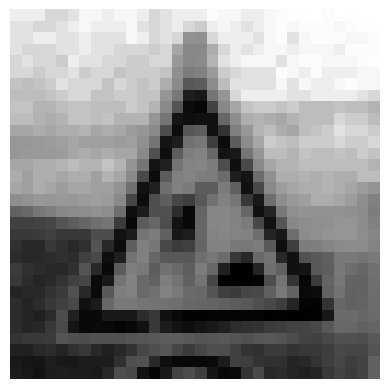

(34799, 32, 32)


In [30]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

def grayscale(img):
    if len(img.shape) == 3 and img.shape[2] == 3:  # Check if the image has 3 channels
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

def equalize(img):
    # Ensure the image is in the correct format (8-bit single-channel)
    if img.dtype != np.uint8:
        img = (img * 255).astype(np.uint8)  # Scale to [0, 255] and convert to uint8
    img = cv2.equalizeHist(img)
    return img

def preprocess(img):
    img = grayscale(img)  # Convert to grayscale
    img = equalize(img)   # Apply histogram equalization
    img = img / 255       # Normalize the image to the range [0, 1]
    return img

# Assuming X_train, X_test, and X_val are already defined
X_train = np.array(list(map(preprocess, X_train)))
X_test = np.array(list(map(preprocess, X_test)))
X_val = np.array(list(map(preprocess, X_val)))

# Display a random preprocessed image
random_index = random.randint(0, len(X_train) - 1)
plt.imshow(X_train[random_index], cmap='gray')
plt.axis('off')
plt.show()
print(X_train.shape)

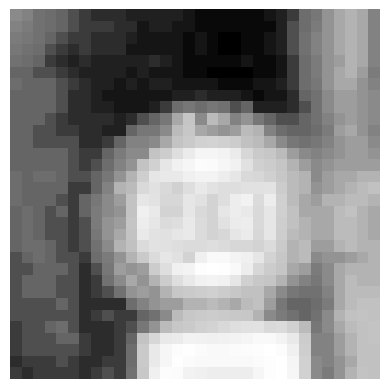

(34799, 32, 32)
(34799, 32, 32, 1)


In [33]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

def grayscale(img):
    if len(img.shape) == 3:  # Check if the image has 3 channels (color image)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

def equalize(img):
    # Ensure the image is in the correct format (8-bit single-channel)
    if img.dtype != np.uint8:
        img = (img * 255).astype(np.uint8)  # Scale to [0, 255] and convert to uint8
    img = cv2.equalizeHist(img)
    return img

def preprocess(img):
    img = grayscale(img)  # Convert to grayscale
    img = equalize(img)   # Apply histogram equalization
    img = img / 255.0     # Normalize the image to the range [0, 1]
    return img

# Assuming X_train, X_test, and X_val are already defined
X_train = np.array(list(map(preprocess, X_train)))
X_test = np.array(list(map(preprocess, X_test)))
X_val = np.array(list(map(preprocess, X_val)))

# Display a random preprocessed image
random_index = random.randint(0, len(X_train) - 1)
plt.imshow(X_train[random_index], cmap='gray')
plt.axis('off')
plt.show()
print(X_train.shape)

# Reshape the data to include a single channel
X_train = X_train.reshape(X_train.shape[0], 32, 32, 1)
X_test = X_test.reshape(X_test.shape[0], 32, 32, 1)
X_val = X_val.reshape(X_val.shape[0], 32, 32, 1)

print(X_train.shape)  # Check the shape after reshaping

In [34]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)

(15, 32, 32, 1)


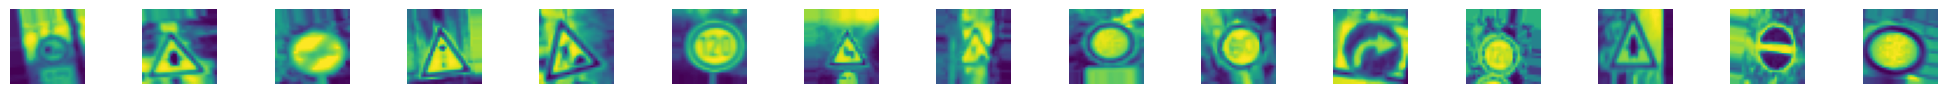

In [35]:

 
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10.)
 
datagen.fit(X_train)
# for X_batch, y_batch in
 
batches = datagen.flow(X_train, y_train, batch_size = 15)
X_batch, y_batch = next(batches)
 
fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()
 
for i in range(15):
    axs[i].imshow(X_batch[i].reshape(32, 32))
    axs[i].axis("off")
 
print(X_batch.shape)

In [39]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Örnek veri oluşturma (sizin verilerinizi buraya yükleyin)
# X_train, X_val, X_test: (num_samples, 32, 32, 1) şeklinde olmalı
# y_train, y_val, y_test: (num_samples,) şeklinde sınıf indeksleri olmalı
np.random.seed(42)
X_train = np.random.rand(34799, 32, 32, 1)  # Örnek eğitim verisi
y_train = np.random.randint(0, 43, size=(34799,))  # Örnek etiketler (0-42 arası)
X_val = np.random.rand(4410, 32, 32, 1)    # Örnek doğrulama verisi
y_val = np.random.randint(0, 43, size=(4410,))    # Örnek etiketler
X_test = np.random.rand(12630, 32, 32, 1)  # Örnek test verisi
y_test = np.random.randint(0, 43, size=(12630,))  # Örnek etiketler

# Etiketleri one-hot encoding'e dönüştür
y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)
y_test = to_categorical(y_test, 43)

# Model oluşturma
def create_model():
    model = Sequential()
    model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
    model.add(Conv2D(60, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(30, (3, 3), activation='relu'))
    model.add(Conv2D(30, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(43, activation='softmax'))
    
    # Modeli derle
    model.compile(Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Modeli oluştur
model = create_model()
print(model.summary())

# Veri artırma (data augmentation)
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2
)
datagen.fit(X_train)

# Modeli eğit
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=50),
    steps_per_epoch=len(X_train) // 50,  # Her epoch'ta tüm veriyi kullan
    epochs=10,
    validation_data=(X_val, y_val),
    shuffle=True
)

# Modeli değerlendir
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 28, 28, 60)     │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 24, 24, 60)     │        90,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 12, 12, 60)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 10, 10, 30)     │        16,230 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 8, 8, 30)       │         8,130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 4, 4, 30)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 480)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 500)            │       240,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 43)             │        21,543 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 378,023 (1.44 MB)

 Trainable params: 378,023 (1.44 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
AttributeError: module 'ml_dtypes' has no attribute 'float8_e3m4'
695/695 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - accuracy: 0.0247 - loss: 3.7621 - val_accuracy: 0.0209 - val_loss: 3.7618
Epoch 2/10
  1/695 ━━━━━━━━━━━━━━━━━━━━ 26s 38ms/step - accuracy: 0.0200 - loss: 3.7646

c:\Users\ENES\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


695/695 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0200 - loss: 3.7646 - val_accuracy: 0.0209 - val_loss: 3.7618
Epoch 3/10
695/695 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.0223 - loss: 3.7611 - val_accuracy: 0.0222 - val_loss: 3.7620
Epoch 4/10
695/695 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0000e+00 - loss: 3.7594 - val_accuracy: 0.0222 - val_loss: 3.7620
Epoch 5/10
695/695 ━━━━━━━━━━━━━━━━━━━━ 29s 42ms/step - accuracy: 0.0235 - loss: 3.7609 - val_accuracy: 0.0218 - val_loss: 3.7620
Epoch 6/10
695/695 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0000e+00 - loss: 3.7560 - val_accuracy: 0.0222 - val_loss: 3.7620
Epoch 7/10
695/695 ━━━━━━━━━━━━━━━━━━━━ 29s 42ms/step - accuracy: 0.0239 - loss: 3.7611 - val_accuracy: 0.0222 - val_loss: 3.7620
Epoch 8/10
695/695 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0400 - loss: 3.7601 - val_accuracy: 0.0222 - val_loss: 3.7620
Epoch 9/10
695/695 ━━━━━━━━━━━━━━━━━━━━ 29s 42ms/step - accuracy: 0.0241 - loss: 3.7607 - val_accurac

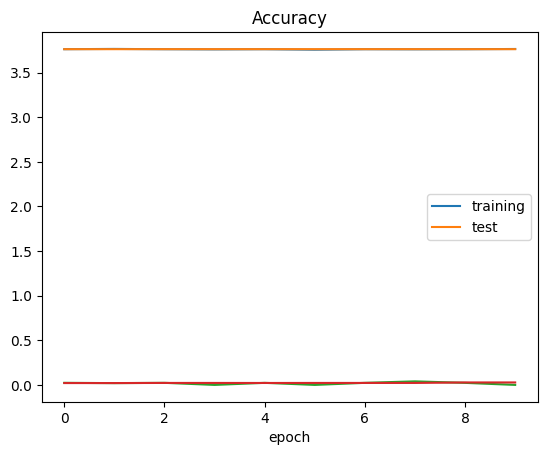

In [40]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')
 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','test'])
plt.title('Accuracy')
plt.xlabel('epoch')
 
# TODO: Evaluate model on test data
score = model.evaluate(X_test, y_test, verbose=0)

Test score: 3.7613422870635986
Test accuracy: 0.022802850231528282
(32, 32)


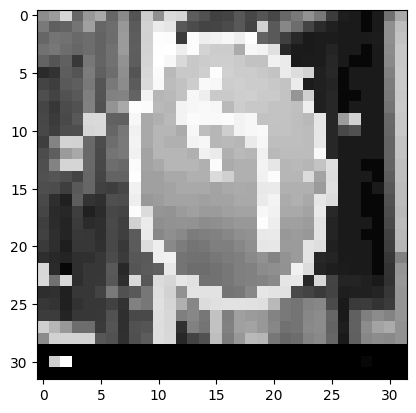

In [41]:
print('Test score:', score[0])
print('Test accuracy:', score[1])
 
#predict internet number
import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))
 
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocess(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)
img = img.reshape(1, 32, 32, 1)
 


In [43]:
predictions = model.predict(img)
predicted_class = np.argmax(predictions, axis=-1)

print("predicted digit:", str(predicted_class[0]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
predicted digit: 13
